# 4B. Classifying Claims - Improving Results with Data

This is an additional notebook to implement the "Improving Results with Data" section of part 4.

## Changing Input Dimensionality

Let's see if increasing or decreasing the dimensionality of our input data affects our classification results. We can do this by changing the number of words cap that is passed to our tokeniser.

In [3]:
import pickle
with open("raw_data.pkl", "rb") as f:
    print("Loading data")
    raw_data = pickle.load(f)
    print("{0} claims and classifications loaded".format(len(data)))

Loading data
11238 claims and classifications loaded


In [4]:
# Create our Y vector as before
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Y_class = [d[1] for d in raw_data]

# encode class values as integers
label_e = LabelEncoder()
label_e.fit(Y_class)
encoded_Y = label_e.transform(Y_class)
# convert integers to dummy variables (i.e. one hot encoded)
Y = to_categorical(encoded_Y)
print("Our classes are now a matrix of {0}".format(Y.shape))
print("Original label: {0}; Converted label: {1}".format(Y_class[0], Y[0]))

Our classes are now a matrix of (11238, 8)
Original label: A; Converted label: [1. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
# Let's start with decreasing our dimensionality

from keras.preprocessing.text import Tokenizer

docs = [d[0] for d in raw_data]

# create the tokenizer
t = Tokenizer(num_words=2500)
# fit the tokenizer on the documents
t.fit_on_texts(docs)

X = t.texts_to_matrix(docs, mode='tfidf')
print("Our data has the following dimensionality: ", X.shape)

Our data has the following dimensionality:  (11238, 2500)


We are going to leave our SVC classifier for these experiments as it took too long to train.

In [7]:
import numpy
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

classifiers = [
    MultinomialNB(),
    MLPClassifier()
]

results = list()
# Convert one hot to target integer
Y_integers = numpy.argmax(Y, axis=1)

for clf in classifiers:
    name = clf.__class__.__name__
    scores = cross_val_score(clf, X, Y_integers, cv=5)
    results.append((
        name, 
        scores.mean()*100, 
        scores.std()*100
    ))
        
    print(
        "Classifier {0} has an average classification accuracy of {1:.2f} ({2:.2f})".format(
            name, 
            scores.mean()*100, 
            scores.std()*100
        )    
    )

Classifier MultinomialNB has an average classification accuracy of 57.04 (0.97)
Classifier MLPClassifier has an average classification accuracy of 60.17 (1.07)


Here are our results:
* Classifier MultinomialNB has an average classification accuracy of 57.04 (0.97)
* Classifier MLPClassifier has an average classification accuracy of 60.17 (1.07)

Comparing with our previous results:
* Classifier MultinomialNB has an average classification accuracy of 58.90 (1.12)
* Classifier MLPClassifier has an average classification accuracy of 61.20 (0.54)

We see a slight reduction in accuracy, although we are on or close to the bounds of variance. Reducing our dimensionality does not seem to be the way to proceed.

Even though our SVC classifier performed well in the spot-checks - it takes a very long time to train. For these more general experiments, we will thus limit to the Naive Bayes and the MLP classifier.

In [8]:
# Now let's increase our dimensionality

# Delete our earlier data
del X, t

from keras.preprocessing.text import Tokenizer

# create the tokenizer
t = Tokenizer(num_words=10000)
# fit the tokenizer on the documents
t.fit_on_texts(docs)

X = t.texts_to_matrix(docs, mode='tfidf')
print("Our data has the following dimensionality: ", X.shape)

# SVC takes too long to train
classifiers = [
    MultinomialNB(),
    MLPClassifier()
]
for clf in classifiers:
    name = clf.__class__.__name__
    scores = cross_val_score(clf, X, Y_integers, cv=5)
    results.append((
        name, 
        scores.mean()*100, 
        scores.std()*100
    ))
        
    print(
        "Classifier {0} has an average classification accuracy of {1:.2f} ({2:.2f})".format(
            name, 
            scores.mean()*100, 
            scores.std()*100
        )    
    )

Our data has the following dimensionality:  (11238, 10000)
Classifier MultinomialNB has an average classification accuracy of 59.26 (1.16)
Classifier MLPClassifier has an average classification accuracy of 62.11 (0.36)


Results:
* Classifier MultinomialNB has an average classification accuracy of 59.26 (1.16)
* Classifier MLPClassifier has an average classification accuracy of 62.11 (0.36)

There does appear to be a small increase in performance (~2% - where variance is ~1%). So more words does help us. However, it does not help as much as we would expect it too (e.g. doubling our number of counted words does not double performance).

This indicates that much of our classification is being performed on a limited set of terms.  

Let's see what another doubling of our dimensionality does...

In [9]:
# Delete our earlier data
del X, t

from keras.preprocessing.text import Tokenizer

# create the tokenizer
t = Tokenizer(num_words=20000)
# fit the tokenizer on the documents
t.fit_on_texts(docs)

X = t.texts_to_matrix(docs, mode='tfidf')
print("Our data has the following dimensionality: ", X.shape)

# SVC takes too long to train
classifiers = [
    MultinomialNB(),
    MLPClassifier()
]
for clf in classifiers:
    name = clf.__class__.__name__
    scores = cross_val_score(clf, X, Y_integers, cv=5)
    results.append((
        name, 
        scores.mean()*100, 
        scores.std()*100
    ))
        
    print(
        "Classifier {0} has an average classification accuracy of {1:.2f} ({2:.2f})".format(
            name, 
            scores.mean()*100, 
            scores.std()*100
        )    
    )

Our data has the following dimensionality:  (11238, 20000)
Classifier MultinomialNB has an average classification accuracy of 59.24 (1.33)
Classifier MLPClassifier has an average classification accuracy of 61.91 (0.43)


Results:
* Classifier MultinomialNB has an average classification accuracy of 59.24 (1.33)
* Classifier MLPClassifier has an average classification accuracy of 61.91 (0.43)

There seems to be a leveling off of performance with increased dimensionality. Here there will always be a trade-off between dimensionality and performance. In this case, as we are only obtaining a small percentage increase, it may be better to use a smaller dimensionality to allow faster classification.

Another aside on speed: the Naive Bayes classifier is much faster to train than the MLP classifier, and the difference in performance is only 1-2%. If we were looking at a production system, there may be a benefit in using the Naive Bayes classifier over the more fancy deep-learning approaches.

## Changing Data Conversion Methods

The texts_to_matrix method for the text tokeniser has for different modes: "binary", "count", "tfidf", "freq". These are not explained but it is presumed that binary provides just an indication of presence for a word, and count/freq provide un-normalised count data. Looking at the [source](https://github.com/keras-team/keras/blob/master/keras/preprocessing/text.py), freq divides the count c by the length of the sequence. 

In [10]:
modes = ["binary", "count", "freq"]

for mode in modes:
    # create the tokenizer
    t = Tokenizer(num_words=5000)
    # fit the tokenizer on the documents
    t.fit_on_texts(docs)

    X = t.texts_to_matrix(docs, mode=mode)
    for clf in classifiers:
        name = clf.__class__.__name__
        scores = cross_val_score(clf, X, Y_integers, cv=5)
        
        print(
            "Mode {0} - Classifier {1} has an average classification accuracy of {2:.2f} ({3:.2f})".format(
                mode,
                name, 
                scores.mean()*100, 
                scores.std()*100
            )    
        )

Mode binary - Classifier MultinomialNB has an average classification accuracy of 57.07 (0.82)
Mode binary - Classifier MLPClassifier has an average classification accuracy of 59.63 (0.71)
Mode count - Classifier MultinomialNB has an average classification accuracy of 57.53 (0.89)
Mode count - Classifier MLPClassifier has an average classification accuracy of 59.00 (0.63)
Mode freq - Classifier MultinomialNB has an average classification accuracy of 30.82 (0.05)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mode freq - Classifier MLPClassifier has an average classification accuracy of 57.65 (1.38)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Results:
* Mode binary - Classifier MultinomialNB has an average classification accuracy of 57.07 (0.82)
* Mode binary - Classifier MLPClassifier has an average classification accuracy of 59.63 (0.71)
* Mode count - Classifier MultinomialNB has an average classification accuracy of 57.53 (0.89)
* Mode count - Classifier MLPClassifier has an average classification accuracy of 59.00 (0.63)
* Mode freq - Classifier MultinomialNB has an average classification accuracy of 30.82 (0.05)
* Mode freq - Classifier MLPClassifier has an average classification accuracy of 57.65 (1.38)

Some interestings results here. TD-IDF appears the best metric to use. Frequency counts appear to cause problems with both classifiers (the MLP does not converge to a solution after 200 iterations). Using TD-IDF over just count data appears to increase performance by 1-2%.

## Increasing Performance with Ensembles

How do each of our preferred machine learning algorithms build their models? If they each have different strengths and weaknesses we may be able to build an ensemble model that outperforms the individual performance.

### Looking at the Confusion Matrix for Insights

Luckily scikit-learn provides a [helpful example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) that shows how to plot a confusion matrix. We will use this code below.

In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.34 0.14 0.22 0.01 0.11 0.07 0.1  0.01]
 [0.02 0.52 0.11 0.03 0.09 0.13 0.07 0.03]
 [0.08 0.1  0.73 0.   0.01 0.02 0.02 0.04]
 [0.   0.   0.25 0.38 0.25 0.12 0.   0.  ]
 [0.   0.14 0.07 0.02 0.62 0.09 0.05 0.02]
 [0.01 0.12 0.02 0.01 0.08 0.69 0.05 0.03]
 [0.01 0.06 0.04 0.   0.01 0.03 0.7  0.16]
 [0.   0.07 0.05 0.01 0.02 0.05 0.23 0.58]]
Normalized confusion matrix
[[0.63 0.1  0.1  0.   0.   0.03 0.07 0.05]
 [0.09 0.53 0.07 0.01 0.02 0.07 0.11 0.11]
 [0.25 0.12 0.48 0.   0.01 0.01 0.04 0.08]
 [0.25 0.25 0.25 0.   0.12 0.   0.   0.12]
 [0.16 0.19 0.03 0.   0.38 0.12 0.07 0.05]
 [0.12 0.17 0.01 0.   0.01 0.48 0.11 0.11]
 [0.04 0.03 0.02 0.   0.   0.02 0.67 0.21]
 [0.02 0.04 0.02 0.   0.   0.02 0.24 0.66]]


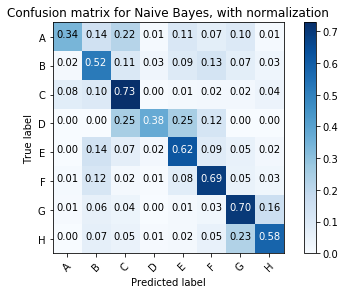

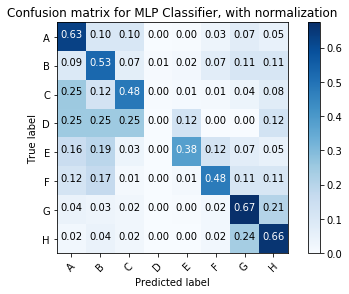

In [16]:
# create the tokenizer
t = Tokenizer(num_words=5000)
# fit the tokenizer on the documents
t.fit_on_texts(docs)

X = t.texts_to_matrix(docs, mode="tfidf")

NBclf = MultinomialNB()
MLPclf = MLPClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, Y_integers, random_state=0)

NB_y_pred = NBclf.fit(X_train, y_train).predict(X_test)
MLP_y_pred = MLPclf.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
NB_cnf_matrix = confusion_matrix(y_test, NB_y_pred)
MLP_cnf_matrix = confusion_matrix(y_test, MLP_y_pred)
np.set_printoptions(precision=2)

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(NB_cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix for Naive Bayes, with normalization')

plt.figure()
plot_confusion_matrix(MLP_cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix for MLP Classifier, with normalization')

plt.show()

#### Observations on the Confusion Matrix

The Naive Bayes classifier performs better than the MLP classifier for Sections C, D, E, F and G. The MLP classifier performs better for Sections A, B, and H. 

This suggests that an ensemble of both classifiers may work at improving performance. scikit-learn has a method to use both hard and soft voting [here](http://scikit-learn.org/stable/modules/ensemble.html).

In [22]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('NB', NBclf))
estimators.append(('MLP', MLPclf))
# create the ensemble model
ensemble = VotingClassifier(estimators)
scores = cross_val_score(ensemble, X, Y_integers, cv=5)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [24]:
scores

array([0.61, 0.59, 0.6 , 0.6 , 0.6 ])

In [25]:
scores.mean()*100

59.89522060313159

In [26]:
scores.std()*100

0.7295624868552363

In [23]:
# Trying soft voting
ensemble = VotingClassifier(estimators, voting = "soft")
scores = cross_val_score(ensemble, X, Y_integers, cv=5)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [27]:
scores

array([0.61, 0.59, 0.6 , 0.6 , 0.6 ])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Normalized confusion matrix
[[0.37 0.14 0.21 0.01 0.09 0.07 0.1  0.02]
 [0.02 0.52 0.11 0.02 0.09 0.12 0.07 0.04]
 [0.08 0.1  0.73 0.   0.01 0.01 0.02 0.04]
 [0.   0.   0.25 0.38 0.25 0.12 0.   0.  ]
 [0.   0.16 0.07 0.02 0.6  0.09 0.05 0.02]
 [0.02 0.12 0.02 0.01 0.07 0.68 0.06 0.04]
 [0.01 0.06 0.04 0.   0.01 0.02 0.7  0.16]
 [0.   0.06 0.04 0.   0.01 0.05 0.23 0.6 ]]


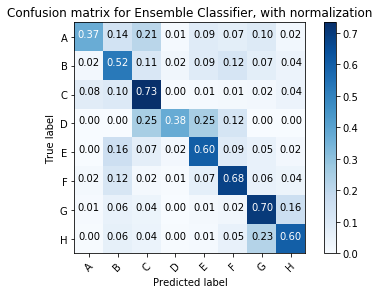

In [28]:
EN_y_pred = ensemble.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
EN_cnf_matrix = confusion_matrix(y_test, EN_y_pred)
np.set_printoptions(precision=2)

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(EN_cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix for Ensemble Classifier, with normalization')

plt.show()